<div style="display: flex; background-color: RGB(245, 203, 167);" >
<h1 style="margin: auto; padding: 30px; ">Analyse en composantes principales</h1>
    </div>

<h3 style="text-align:center;">Auteur : Julien SERE | Date : 2025-3-2</h3>

## Importation des librairies

In [106]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids 
# Configuration des options
pd.set_option('display.max_colwidth', None)




## Importation du merge

In [108]:
file_path = "C://Users//julie//Downloads//OC Formation//P11//Données//data_final.csv"
try:
    data = pd.read_csv(file_path, encoding='latin_1',index_col=0)
    print("Données chargées avec succès.")
except Exception as e:
    print(f"Erreur lors du chargement des données : {e}")


Données chargées avec succès.


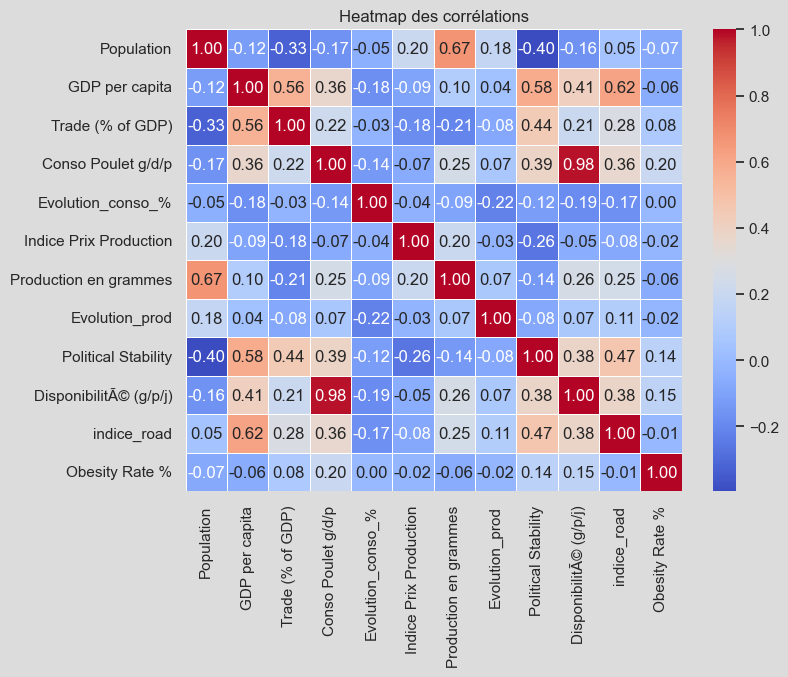

In [109]:
#Identification des colonnes à exclure de l'ACP (sans corrélations particulières
corr_matrix_data = data.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap des corrélations")
plt.show()



In [110]:
corr_matrix_data_abs = data.corr().abs()
sum_corr = corr_matrix_data_abs.sum() - 1   # -1 pour exclure la corrélation avec soi-même

# Trier par ordre croissant
low_corr_vars = sum_corr.sort_values()

print(low_corr_vars)

Obesity Rate %            0.809769
Evolution_prod            0.959024
Evolution_conso_%         1.238243
Indice Prix Production    1.241127
Production en grammes     2.315778
Population                2.411069
Trade (% of GDP)          2.624493
indice_road               2.760590
GDP per capita            3.135673
Conso Poulet g/d/p        3.200860
DisponibilitÃ© (g/p/j)    3.250087
Political Stability       3.402584
dtype: float64


La colonne Indice Prix Production, qui ne représente pas un facteur majeur dans la stratégie que l'on va adopter, et qui est très peu corrélée fait moins sens pour une analyse en composantes principales. Je décide de la retirer uniquement pour notre ACP et la stocker dans une variable.
Egalement, la colonne portant sur l'évolution de la production est très peu corrélé aux autres variables, je décide également de la retirer uniquement pour notre ACP et la stocker dans une variable.

La colonne obésité fait également peu sens étant donné sa faible corrélation avec les autres variables.

In [111]:
indice_prix = data['Indice Prix Production']
data = data.drop(columns =  ['Indice Prix Production'])

evolution_prod = data['Evolution_prod']
data = data.drop(columns =  ['Evolution_prod'])

obesite = data['Obesity Rate %']
data = data.drop(columns =  ['Obesity Rate %'])



In [112]:
x = data.values
countries = data.index
features = data.columns

## Normalisation

In [113]:
std_scale = StandardScaler()
std_scale.fit(x)
x_scaled = std_scale.transform(x)

## ACP

In [114]:
components = data.shape[1]
pca = PCA(n_components=components)

X_pca = pca.fit_transform(x_scaled)
pca.fit(x_scaled)



PCA(n_components=9)

### Eboulis des valeurs propres

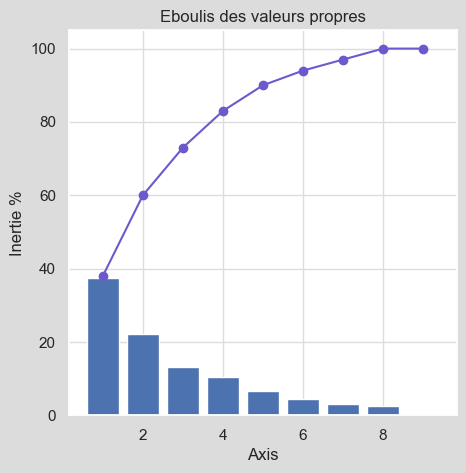

In [115]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
a_list = range(1, components+1)
list(a_list)

# plot data
plt.figure(figsize=(5,5))
plt.bar(a_list, scree,)
plt.plot(a_list, scree_cum,color='slateblue',marker='o')
plt.xlabel("Axis")
plt.ylabel("Inertie %")
plt.title("Eboulis des valeurs propres")
plt.grid(axis='both', color='gainsboro')
plt.savefig("eboulis.png", bbox_inches='tight')
plt.show(block=False)

On peut appliquer l'ACP à 4 dimensions, qui explique près de 80% de la variance totale.

In [116]:
# 3. Appliquer l'ACP
pca = PCA(n_components=4)  # Réduction à 4 dimensions
X_pca = pca.fit_transform(x_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=data.index)
df_pca

,PC1,PC2,PC3,PC4
country,,,,
Armenia,-0.729892,-0.776711,0.309807,-0.105405
Australia,2.585643,1.712866,0.818043,0.213310
Ireland,3.994592,-1.050104,-1.206205,0.043327
Israel,2.448086,1.917302,2.925485,-0.022855
Italy,0.567673,1.153773,-0.991073,0.049251
...,...,...,...,...
Honduras,-0.396708,-0.206588,0.665576,-0.083072
"China, Hong Kong SAR",4.878910,-1.144790,-0.645607,0.902700
Hungary,1.164321,-0.749964,-0.350825,-0.153276


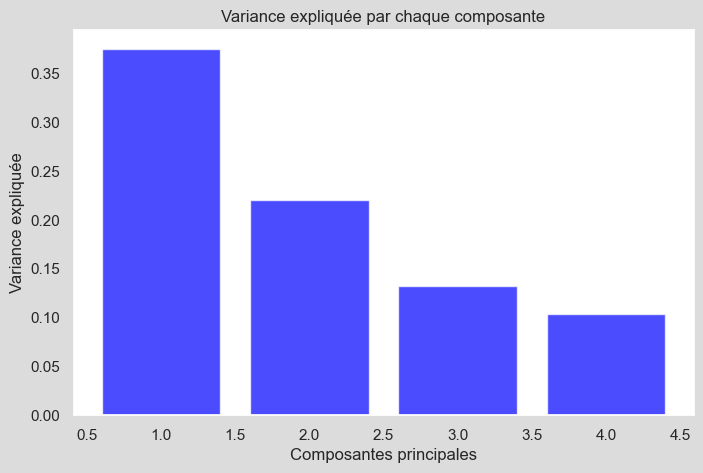

In [117]:
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.7, align='center', color='blue')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante')
plt.show()

## Clustering

### Classification hierarchique

#### Dendogramme

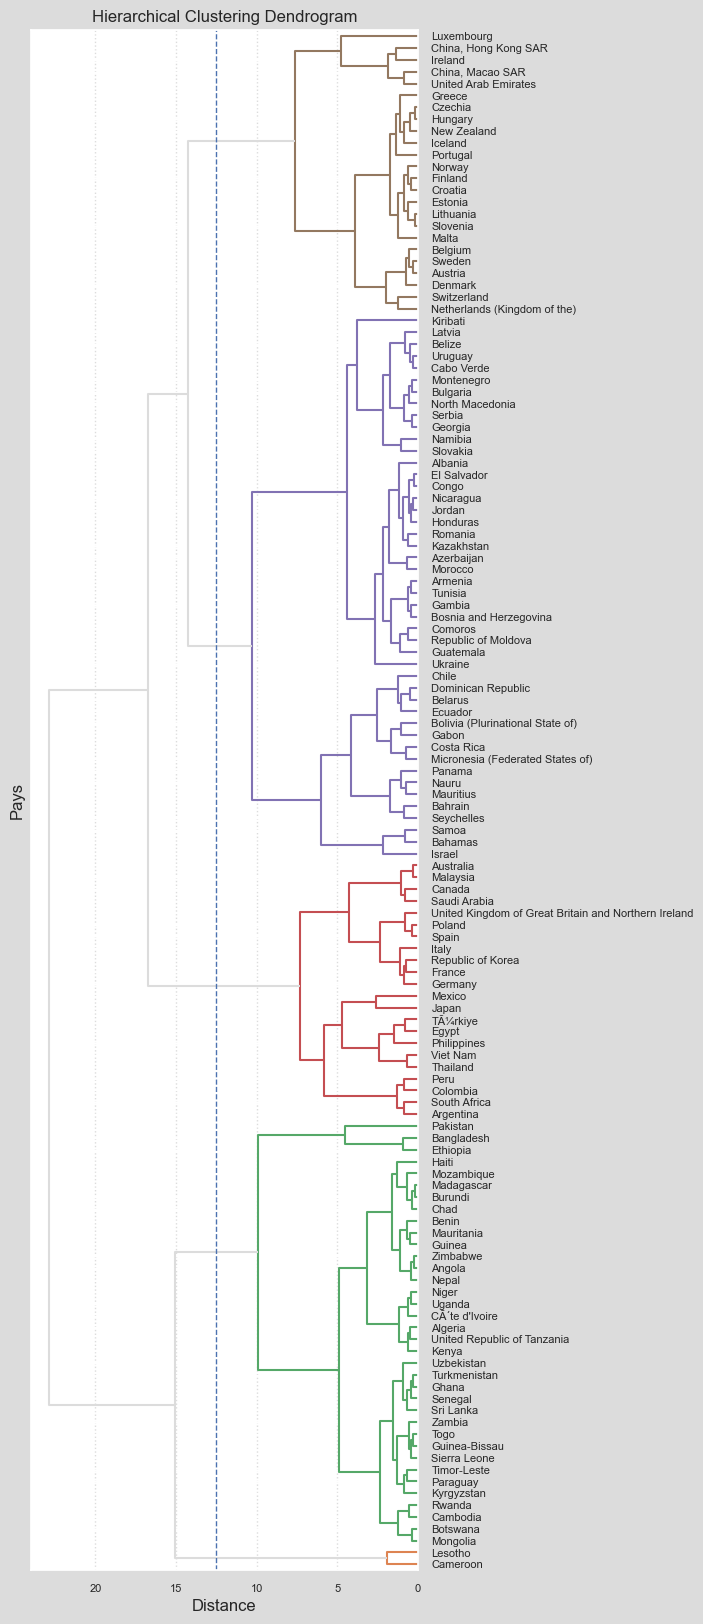

In [118]:
# Dendogramme
Z = shc.linkage(df_pca, method="ward", optimal_ordering=True,
                metric='euclidean') 

limit = 12.5
fig, ax = plt.subplots(1, 1, figsize=(5,20))
detailed_dendro = shc.dendrogram(Z, ax=ax, labels=countries, orientation = "left", color_threshold=limit,
                        leaf_rotation=0, above_threshold_color='gainsboro', leaf_font_size=6)
plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid(axis='x', color='gainsboro', linestyle='dotted')
plt.axvline(x=limit, lw=1, linestyle='dashed')
plt.savefig("detailed_dendro_v.png", bbox_inches='tight')
plt.show()

On peut distinguer 5 clusters dans notre jeu de données, cependant, Le Cameroun et Lesotho forment un cluster à eux tout seuls, au vu de leurs situations vis à vis du marché du poulet, nous prenons la décision de les supprimer de notre jeu de données pour obtenir un clustering hierarchique plus précis.

In [119]:
df_pca = df_pca.reset_index()
df_pca = df_pca[df_pca['country'] != 'Cameroon']
df_pca = df_pca[df_pca['country'] != 'Lesotho']



In [120]:
data = data.reset_index()
data = data[data['country'] != 'Cameroon']
data = data[data['country'] != 'Lesotho']


In [121]:
df_pca = df_pca.set_index('country')

In [122]:
data = data.set_index('country')

In [123]:
x = data.values
countries = data.index
features = data.columns

In [124]:
std_scale = StandardScaler()
std_scale.fit(x)
x_scaled = std_scale.transform(x)

In [125]:
components = data.shape[1]
pca = PCA(n_components=4)

X_pca = pca.fit_transform(x_scaled)
pca.fit(x_scaled)

PCA(n_components=4)

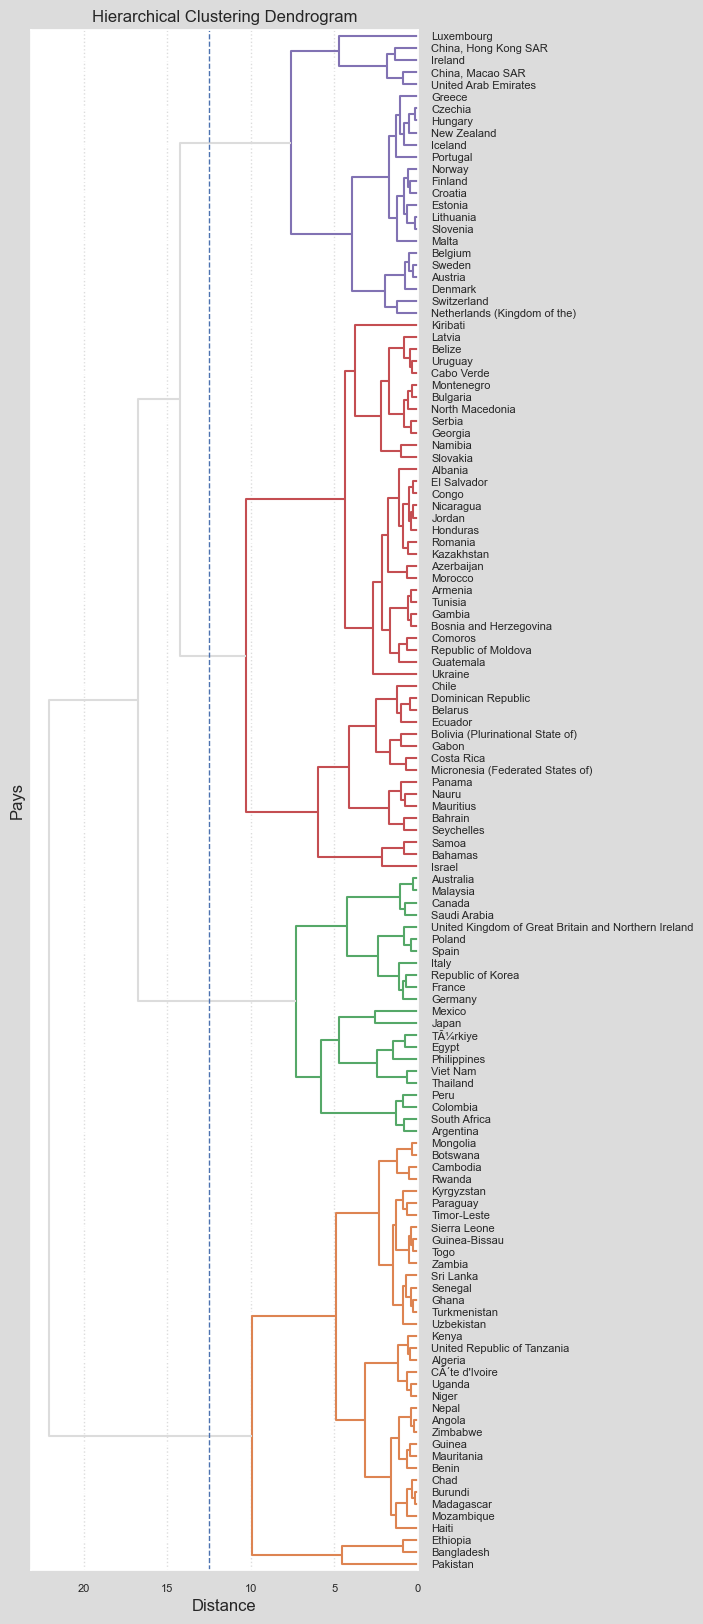

In [126]:
# Dendogramme
Z = shc.linkage(df_pca, method="ward", optimal_ordering=True,
                metric='euclidean') 

limit = 12.5
fig, ax = plt.subplots(1, 1, figsize=(5,20))
detailed_dendro = shc.dendrogram(Z, ax=ax, labels=df_pca.index, orientation = "left", color_threshold=limit,
                        leaf_rotation=0, above_threshold_color='gainsboro', leaf_font_size=6)
plt.title("Hierarchical Clustering Dendrogram")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid(axis='x', color='gainsboro', linestyle='dotted')
plt.axvline(x=limit, lw=1, linestyle='dashed')
plt.savefig("detailed_dendro_v.png", bbox_inches='tight')
plt.show()

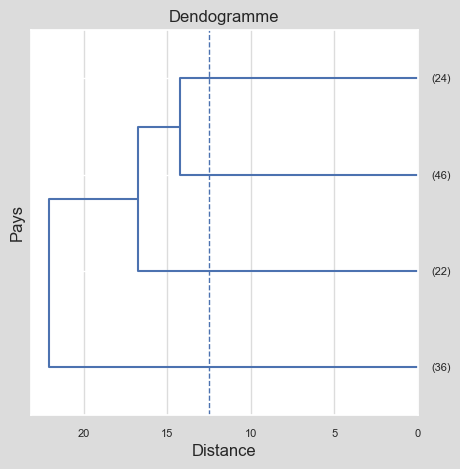

In [127]:
# plot dendrogram with 4 clusters & number of countries in each cluster
nb_clusters_dendro = 4
fig, ax = plt.subplots(1, 1, figsize=(5,5))
dendro_4clust = shc.dendrogram(Z, ax=ax, labels=df_pca.index, orientation = "left",
                         truncate_mode = 'lastp', p=nb_clusters_dendro, color_threshold=limit,
                         leaf_font_size=12, leaf_rotation=0)
plt.title("Dendogramme")
ax.set_xlabel("Distance")
ax.set_ylabel("Pays")
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=8)
plt.grid(axis='x', color='gainsboro')
plt.axvline(x=limit, lw=1, linestyle='dashed')
plt.savefig("dendro_4clust.png", bbox_inches='tight')
plt.show()

In [128]:
# print list of countries in each cluster
k = nb_clusters_dendro
dendro_clusters = shc.fcluster(Z, k, criterion='maxclust')
data_clust = pd.DataFrame({"pays" : countries, "cluster_dendro" : dendro_clusters})

for i in range(1, k+1) : 
    # select cluster
    sub_data_clust = data_clust.loc[data_clust['cluster_dendro'] == i]
    # print cluster
    print(f"cluster : {i}")
    # select country
    pays_list = sub_data_clust['pays'].values
    # create list of countries
    txt = [f"{p}" for p in pays_list]
    # add countries to list
    txt = " / ".join(txt)
    # print clusters
    print(txt)
    print("\n\n")

cluster : 1
CÃ´te d'Ivoire / Kyrgyzstan / Kenya / Cambodia / Madagascar / Mauritania / Mongolia / Mozambique / Nepal / Niger / Bangladesh / Pakistan / Paraguay / Guinea-Bissau / Timor-Leste / Zimbabwe / Rwanda / Senegal / Sierra Leone / Botswana / Turkmenistan / United Republic of Tanzania / Togo / Uganda / Uzbekistan / Ethiopia / Zambia / Burundi / Sri Lanka / Chad / Algeria / Benin / Angola / Ghana / Guinea / Haiti



cluster : 2
Australia / Italy / Japan / Republic of Korea / Malaysia / Mexico / Peru / Philippines / Poland / Saudi Arabia / South Africa / Spain / Thailand / TÃ¼rkiye / United Kingdom of Great Britain and Northern Ireland / Viet Nam / Canada / Colombia / Egypt / France / Germany / Argentina



cluster : 3
Armenia / Israel / Kazakhstan / Jordan / Latvia / Bahamas / Bahrain / Mauritius / Morocco / Micronesia (Federated States of) / Republic of Moldova / Namibia / Nauru / North Macedonia / Nicaragua / Panama / Romania / Bolivia (Plurinational State of) / Seychelles / Slov

In [129]:
# Faire une copie du DataFrame et ajouter les informations de cluster
data_dendro = data.copy().reset_index()

# Effectuer la fusion et définir l'index sans utiliser inplace=True
clusters = pd.merge(data_dendro, data_clust, how='left', left_on='country', right_on='pays').drop(['pays'], axis=1)

# Définir 'country' comme index et assigner le résultat à 'clusters'
clusters.set_index('country', inplace=True)

clusters['cluster_dendro'] = pd.factorize(clusters['cluster_dendro'])[0] + 1

# Afficher les moyennes des clusters
clusters_dendro_avg = clusters.groupby('cluster_dendro').mean()

In [130]:
clusters

,Population,GDP per capita,Trade (% of GDP),Conso Poulet g/d/p,Evolution_conso_%,Production en grammes,Political Stability,DisponibilitÃ© (g/p/j),indice_road,cluster_dendro
country,,,,,,,,,,
Armenia,2943393.0,19230.190,119.714645,8.649997,17.687028,1.380000e+10,-0.829278,8.36,3.62,1
Australia,26451124.0,59552.880,49.225185,22.299995,2.106214,1.431791e+12,0.917057,22.15,4.77,2
Ireland,5196630.0,114922.390,237.215880,15.270015,-26.515773,1.487400e+11,0.901912,20.10,4.48,3
Israel,9256314.0,48432.110,57.528250,31.870010,-3.511958,5.813120e+11,-1.464848,32.55,4.99,1
Italy,59499453.0,53312.070,66.240105,9.520000,-1.449281,1.083180e+12,0.583321,9.34,4.39,2
...,...,...,...,...,...,...,...,...,...,...
Honduras,10644851.0,6468.302,97.953476,10.720004,17.158539,2.413914e+11,-0.459217,11.73,4.06,1
"China, Hong Kong SAR",7442734.0,64467.574,352.798650,26.660000,7.760637,2.364187e+10,0.673061,20.65,6.06,3
Hungary,9686463.0,40543.992,157.296220,11.660007,-7.239396,3.789800e+11,0.731892,10.80,3.89,3


#### Visualisations des clusters par variable

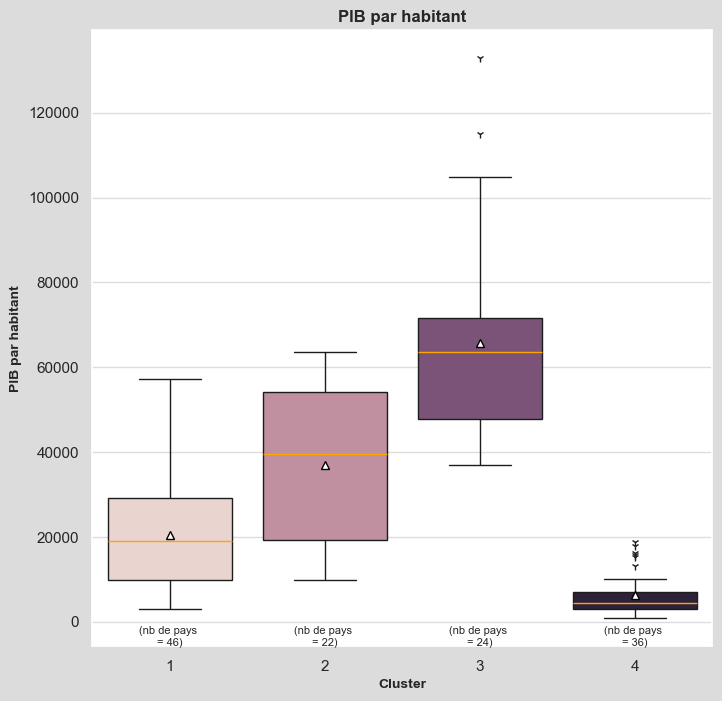

In [131]:
#GDP
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="GDP per capita", hue="cluster_dendro", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('PIB par habitant', fontweight='bold', fontsize=10)
plt.title('PIB par habitant', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
clusters.reset_index(inplace=True)
clusters.rename(columns={'index': 'country'}, inplace=True)

nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, -1000,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -1000,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -1000,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -1000,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_gdp.png", bbox_inches='tight')
plt.show()

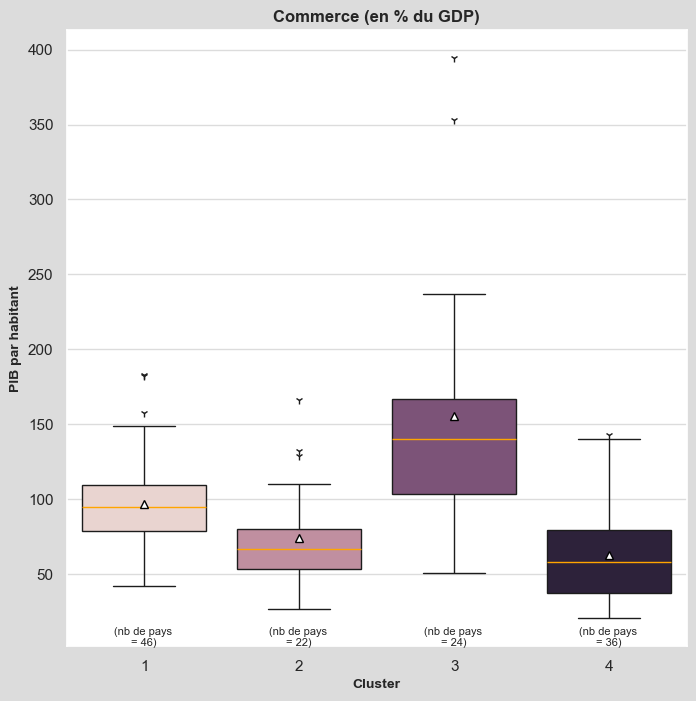

In [132]:
#Trades
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="Trade (% of GDP)", hue="cluster_dendro", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('PIB par habitant', fontweight='bold', fontsize=10)
plt.title('Commerce (en % du GDP)', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, 15,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 15,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 15,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, 15,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_trades.png", bbox_inches='tight')
plt.show()

In [133]:
print(clusters['cluster_dendro'].value_counts())


cluster_dendro
1    46
4    36
3    24
2    22
Name: count, dtype: int64


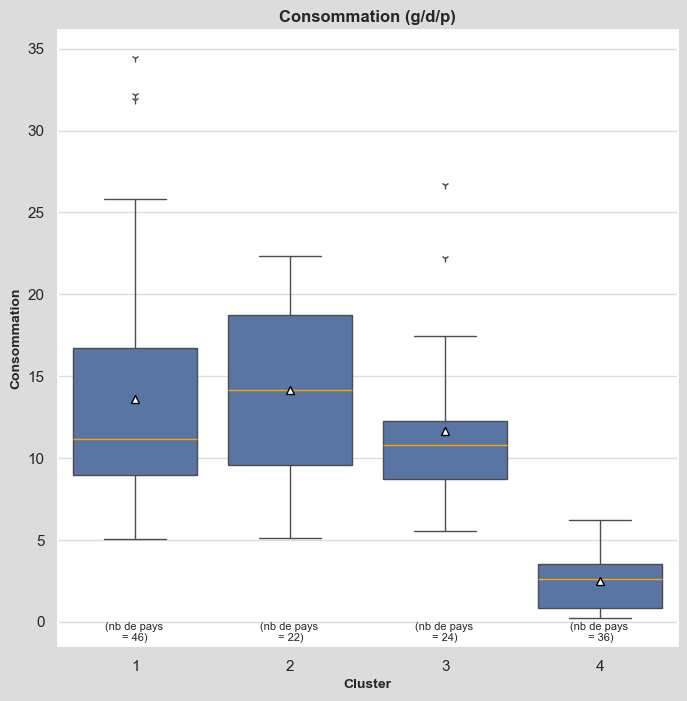

In [134]:
#Conso
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="Conso Poulet g/d/p", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Consommation', fontweight='bold', fontsize=10)
plt.title('Consommation (g/d/p)', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, 0,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 0,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 0,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, 0,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_conso.png", bbox_inches='tight')
plt.show()

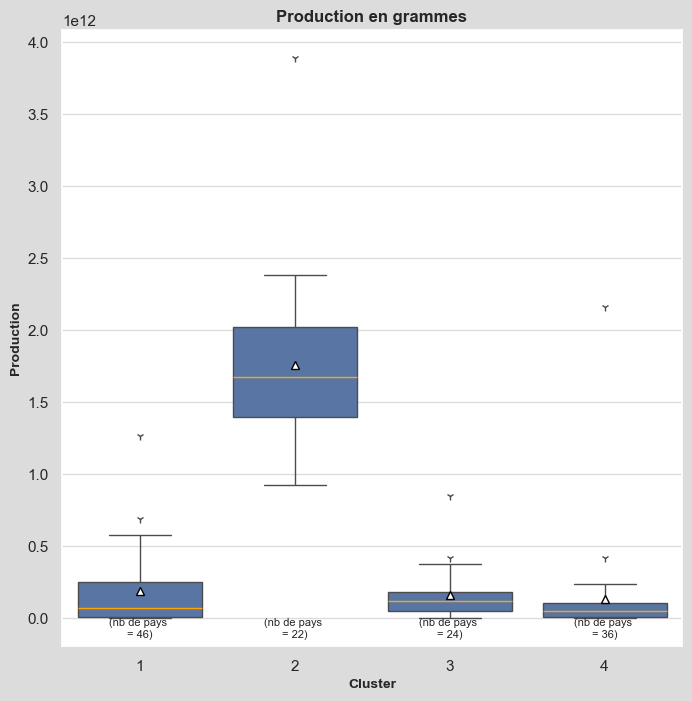

In [135]:
#Production
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="Production en grammes", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Production', fontweight='bold', fontsize=10)
plt.title('Production en grammes', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, 0,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 0,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 0,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, 0,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)

plt.savefig("dendro_box_prod.png", bbox_inches='tight')
plt.show()

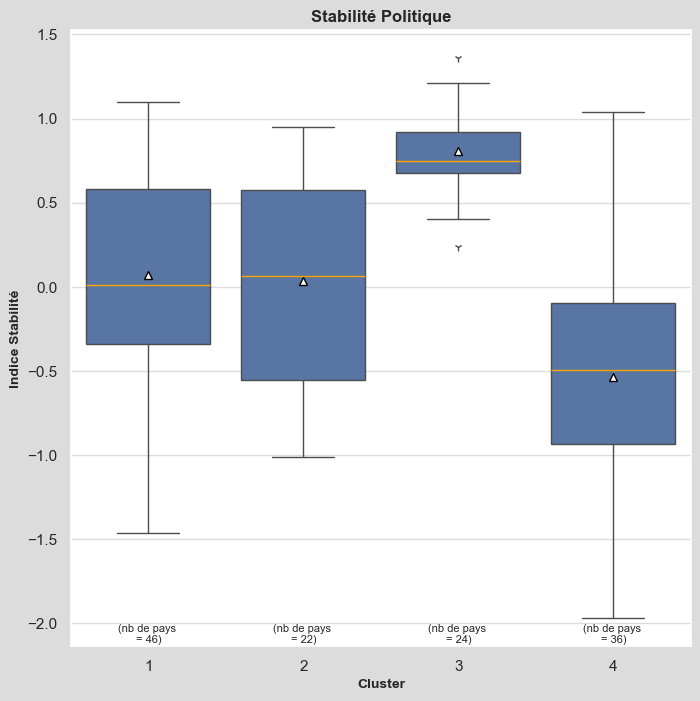

In [136]:
#Political
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="Political Stability", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Indice Stabilité', fontweight='bold', fontsize=10)
plt.title('Stabilité Politique', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, -2,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -2,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -2,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, -2,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_politique.png", bbox_inches='tight')
plt.show()

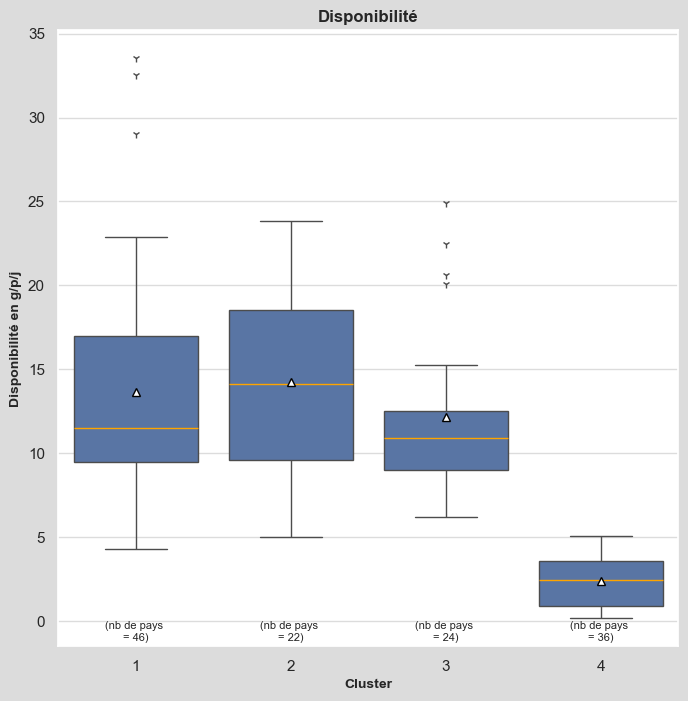

In [137]:
#DisponibilitÃ© (g/p/j)
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="DisponibilitÃ© (g/p/j)", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Disponibilité en g/p/j', fontweight='bold', fontsize=10)
plt.title('Disponibilité', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays_4 = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, 0,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 0,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 0,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, 0,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_dispo.png", bbox_inches='tight')
plt.show()

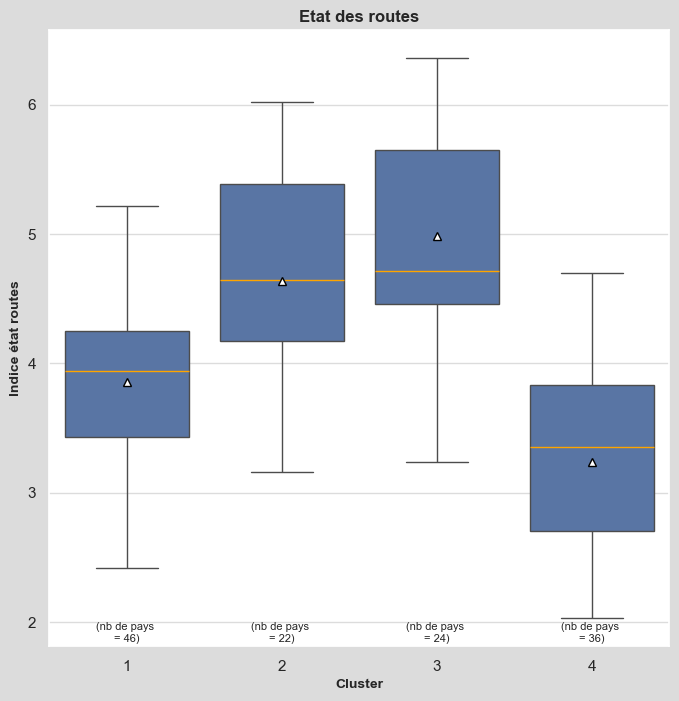

In [138]:
#Road
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="indice_road", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Indice état routes', fontweight='bold', fontsize=10)
plt.title('Etat des routes', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, 2,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 2,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 2,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, 2,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_roads.png", bbox_inches='tight')
plt.show()

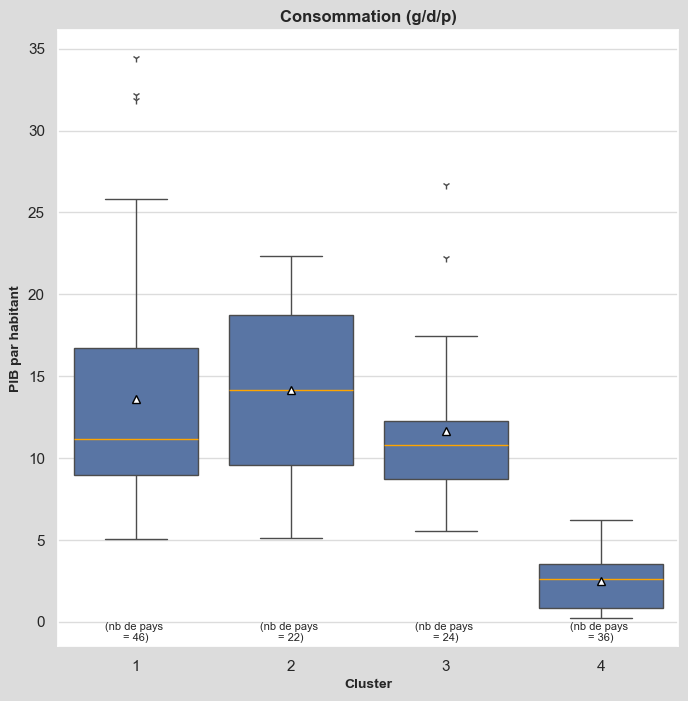

In [140]:
#Conso
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters, x="cluster_dendro", y="Conso Poulet g/d/p", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('PIB par habitant', fontweight='bold', fontsize=10)
plt.title('Consommation (g/d/p)', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters.groupby('cluster_dendro')['country'].count().reset_index()
plt.text(0, 0,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 0,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 0,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(3, 0,"(nb de pays \n= {})".format(nb_pays.iloc[3, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("dendro_box_conso.png", bbox_inches='tight')
plt.show()

### K Means

#### Indice de coude

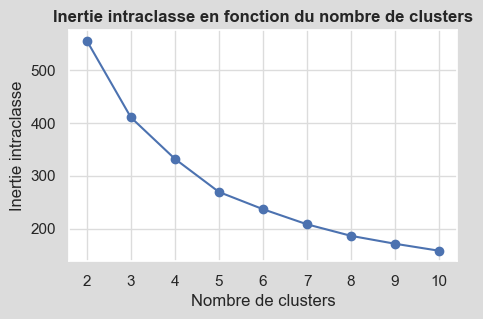

In [141]:
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Éviter la fuite mémoire sous Windows
os.environ["OMP_NUM_THREADS"] = "1"

# Liste de k entre 2 et le nombre de colonnes de x_scaled
k_list = range(2, 11)  # Tester de 2 à 10 clusters


# Liste pour stocker l'inertie intra-classe
wcss = []

for i in k_list:
    kmeans_wcss = KMeans(n_clusters=i, init='k-means++', algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
    kmeans_wcss.fit(df_pca)
    wcss.append(kmeans_wcss.inertia_)

# Tracer la courbe du coude
fig, ax = plt.subplots(figsize=(5, 3))
ax.set_ylabel("Inertie intraclasse")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Inertie intraclasse en fonction du nombre de clusters", fontsize=12, fontweight='bold')
plt.plot(k_list, wcss, marker='o', linestyle='-')
plt.xticks(np.arange(min(k_list), max(k_list) + 1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("kmeans_coude.png", bbox_inches='tight')
plt.show()


Pas de coude évident à l'oeil nu, même si on peut deviner une légère flexion pour  k=4 . on teste une autre méthode

#### Silhouette score

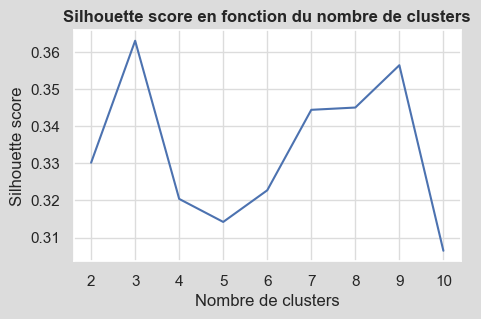

In [142]:
silhouette = []

for j in k_list :
    kmeans_silh = KMeans(n_clusters=j, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30,max_iter=300, verbose=0)
    kmeans_silh.fit(df_pca)
    silh = silhouette_score(df_pca, kmeans_silh.labels_)
    silhouette.append(silh)
    
# plot silhouette score curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel("Silhouette score")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Silhouette score en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, silhouette)
plt.xticks(np.arange(min(k_list), max(k_list)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("silhouette.png", bbox_inches='tight')
plt.show()

#### Indice de Davis Bouldin

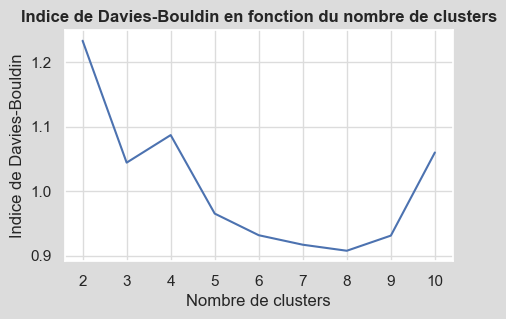

In [144]:
# calculate score for number of K-means clusters between 2 and 11
dav_bould = []

for h in k_list :
    kmeans_db = KMeans(n_clusters=h, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30,max_iter=300,verbose=0)
    kmeans_db.fit(x_scaled)
    d_b = davies_bouldin_score(df_pca, kmeans_db.labels_)
    dav_bould.append(d_b)

# plot Davies-Bouldin score curve
fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.set_ylabel("Indice de Davies-Bouldin")
ax.set_xlabel("Nombre de clusters")
ax.set_title("Indice de Davies-Bouldin en fonction du nombre de clusters", fontsize=12, fontweight='bold')
ax = plt.plot(k_list, dav_bould)
plt.xticks(np.arange(min(k_list), max(k_list)+1, 1.0))
plt.grid(axis='both', color='gainsboro')
plt.savefig("davies_bouldin.png", bbox_inches='tight')
plt.show()

Les différents indices nous suggère un clustering plutôt large. Nous procederons donc au clustering sur 3 clusters, qui est le plus cohérent avec nos différents indices afin de comparer les resultats avec ceux du dendogramme et constater l'ampleur des differences observees.


#### Création K Means Clustering 3

In [145]:
# Exécuter K-Means sur les données déjà réduites en PCA
kmeans_3 = KMeans(n_clusters=3, init='k-means++', copy_x=True, algorithm='lloyd', n_init=30, max_iter=300, verbose=0)
kmeans_3.fit(X_pca)

# Ajouter les labels aux clusters
clusters['cluster_km_3'] = kmeans_3.labels_  # ⚠️ Pas de +1 ici !

# Récupérer les centroïdes et créer un DataFrame
features_pca = [f"PC{i+1}" for i in range(X_pca.shape[1])]
centroids = kmeans_3.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=features_pca)

# Ajouter un identifiant de cluster (de 0 à 2)
centroids_df['Cluster'] = range(0, 3)  # ⚠️ On reste aligné avec k-means !

# Afficher le tableau des centroïdes
print(centroids_df)

# ✅ Afficher les pays de chaque cluster (indices de 0 à 2)
for i in range(3):
    cluster_countries = clusters.loc[clusters['cluster_km_3'] == i]['country'].tolist()
    print(f'Pays du {i+1}ème cluster - {len(cluster_countries)} pays:\n', cluster_countries)


        PC1       PC2       PC3       PC4  Cluster
0  1.804414 -0.620693  0.180551 -0.159990        0
1 -1.357872 -0.549688 -0.177751  0.014297        1
2  0.534774  2.378323  0.159050  0.219955        2
Pays du 1ème cluster - 40 pays:
 ['Ireland', 'Austria', 'Latvia', 'Bahamas', 'Lithuania', 'China, Macao SAR', 'Bahrain', 'Malta', 'Mauritius', 'Micronesia (Federated States of)', 'Nauru', 'Netherlands (Kingdom of the)', 'New Zealand', 'Norway', 'Panama', 'Czechia', 'Portugal', 'Seychelles', 'Slovenia', 'Slovakia', 'Sweden', 'Switzerland', 'United Arab Emirates', 'Belize', 'Samoa', 'Belgium', 'Luxembourg', 'Bulgaria', 'Cabo Verde', 'Costa Rica', 'Denmark', 'Dominican Republic', 'Belarus', 'Estonia', 'Finland', 'Greece', 'China, Hong Kong SAR', 'Hungary', 'Croatia', 'Iceland']
Pays du 2ème cluster - 63 pays:
 ['Armenia', "CÃ´te d'Ivoire", 'Kazakhstan', 'Jordan', 'Kyrgyzstan', 'Kenya', 'Cambodia', 'Madagascar', 'Mauritania', 'Mongolia', 'Morocco', 'Mozambique', 'Republic of Moldova', 'Nam

Pour 3 clusters :

Il y a des groupes assez différents, on distingue déjà un groupe de grands producteurs de poulet, le 3eme cluster.
Egalement un groupe de grand consommateur, le 1er cluster.
Et un groupe de pays encore peu développés, le 2eme cluster.

On garde l'analyse sur 4 clusters, qui est plus cohérente avec l'indice du coude, le silhouette et l'indice Davis.

#### Visualisation du modèle k means choisi (Clustering 3)

In [148]:
data_clust = pd.DataFrame({"pays": countries, "cluster_kmeans": kmeans_3.labels_})


# Faire une copie du DataFrame et ajouter les informations de cluster
data_kmeans = df_pca.copy().reset_index()

# Fusionner les résultats de KMeans avec les données initiales
clusters_3 = pd.merge(data_kmeans, data_clust, how='left', left_on='country', right_on='pays').drop(['pays'], axis=1)
clusters_3_var = pd.merge(data, data_clust, how='left', left_on='country', right_on='pays').drop(['pays'], axis=1)
# Définir 'country' comme index
clusters_3.set_index('country', inplace=True)


In [149]:
clusters_3 = clusters_3.rename(columns={'cluster_kmeans' : 'Cluster'})

In [150]:
# Regrouper les pays par cluster et les afficher
clusters_grouped = clusters_3.groupby("Cluster")["Cluster"].apply(lambda x: list(x.index))

# Afficher chaque cluster avec ses pays
for cluster, country in clusters_grouped.items():
    print(f"\n🌍 **Cluster {cluster}** :")
    print(", ".join(country))


🌍 **Cluster 0** :
Ireland, Austria, Latvia, Bahamas, Lithuania, China, Macao SAR, Bahrain, Malta, Mauritius, Micronesia (Federated States of), Nauru, Netherlands (Kingdom of the), New Zealand, Norway, Panama, Czechia, Portugal, Seychelles, Slovenia, Slovakia, Sweden, Switzerland, United Arab Emirates, Belize, Samoa, Belgium, Luxembourg, Bulgaria, Cabo Verde, Costa Rica, Denmark, Dominican Republic, Belarus, Estonia, Finland, Greece, China, Hong Kong SAR, Hungary, Croatia, Iceland

🌍 **Cluster 1** :
Armenia, CÃ´te d'Ivoire, Kazakhstan, Jordan, Kyrgyzstan, Kenya, Cambodia, Madagascar, Mauritania, Mongolia, Morocco, Mozambique, Republic of Moldova, Namibia, Nepal, North Macedonia, Nicaragua, Niger, Bangladesh, Paraguay, Guinea-Bissau, Timor-Leste, Zimbabwe, Romania, Rwanda, Bolivia (Plurinational State of), Senegal, Sierra Leone, Botswana, Turkmenistan, United Republic of Tanzania, Togo, Tunisia, Uganda, Ukraine, Uruguay, Uzbekistan, Ethiopia, Zambia, Serbia, Montenegro, Burundi, Albania

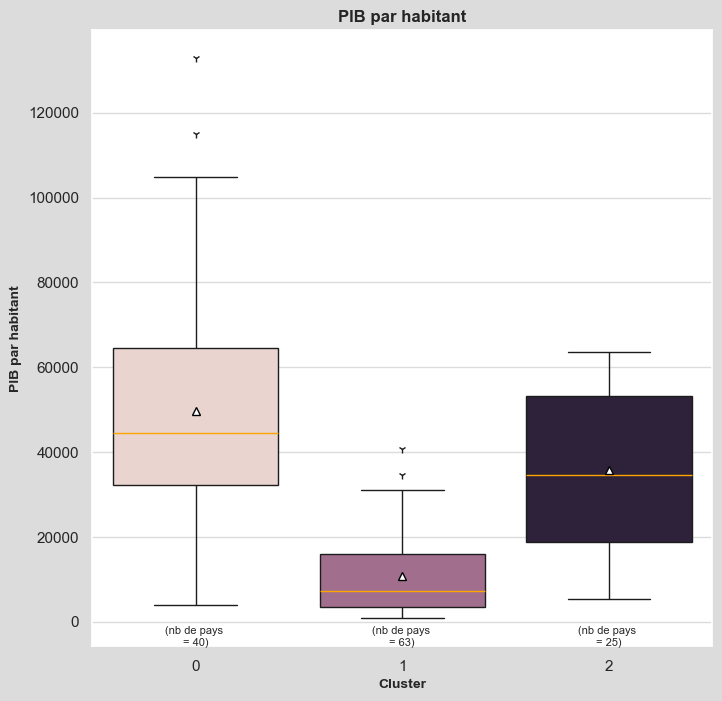

In [152]:
#GDP
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters_3_var, x="cluster_kmeans", y="GDP per capita", hue="cluster_kmeans", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('PIB par habitant', fontweight='bold', fontsize=10)
plt.title('PIB par habitant', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

# add number of countries in each cluster
clusters_3_var.reset_index(inplace=True)
clusters_3_var.rename(columns={'index': 'country'}, inplace=True)

nb_pays = clusters_3_var.groupby('cluster_kmeans')['country'].count().reset_index()
plt.text(0, -1000,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -1000,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -1000,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("kmeans_box_gdp.png", bbox_inches='tight')
plt.show()

Le cluster 0 regroupe les pays qui ont le PIB moyen par habitant le plus élevé, suivi par le cluster 2 qui a un niveau de vie acceptable pour l'implantation d'un business.

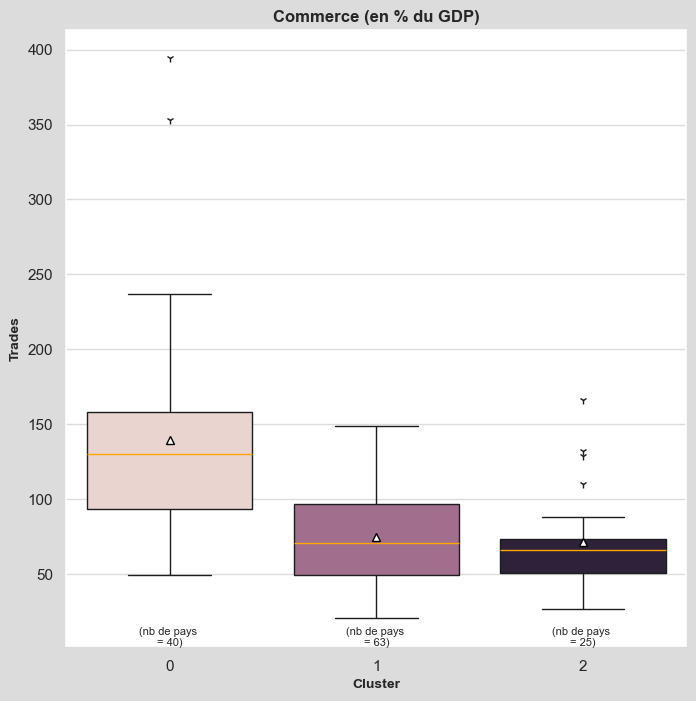

In [153]:
#Trades
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters_3_var, x="cluster_kmeans", y="Trade (% of GDP)", hue="cluster_kmeans", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Trades', fontweight='bold', fontsize=10)
plt.title('Commerce (en % du GDP)', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters_3_var.groupby('cluster_kmeans')['country'].count().reset_index()
plt.text(0, 15,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 15,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 15,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("kmeans_box_trades.png", bbox_inches='tight')
plt.show()

Taux d'ouverture commercial très intéressant pour le cluster 0.

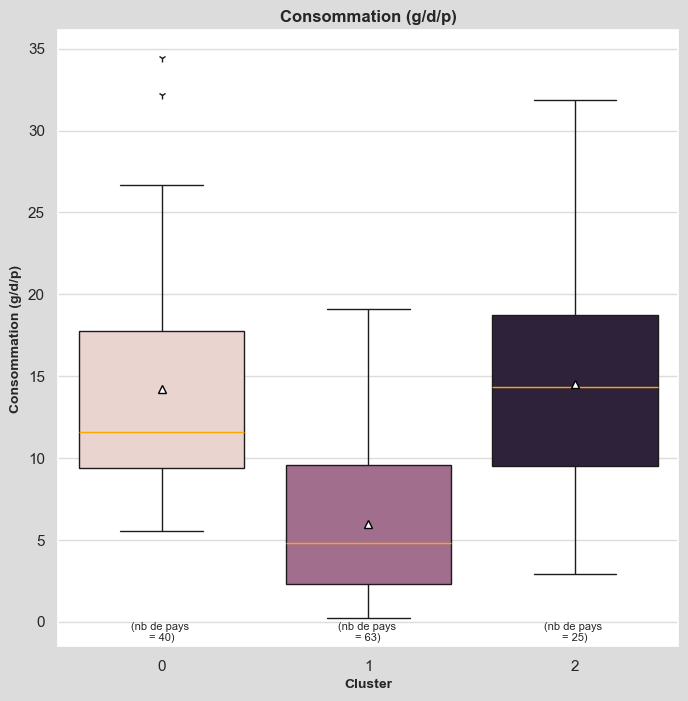

In [154]:
#Conso
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters_3_var, x="cluster_kmeans", y="Conso Poulet g/d/p", hue="cluster_kmeans", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Consommation (g/d/p)', fontweight='bold', fontsize=10)
plt.title('Consommation (g/d/p)', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters_3_var.groupby('cluster_kmeans')['country'].count().reset_index()
plt.text(0, 0,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 0,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 0,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("kmeans_box_conso.png", bbox_inches='tight')
plt.show()

Les clusters 1 et 2 sont intéressant en terme de consommation.

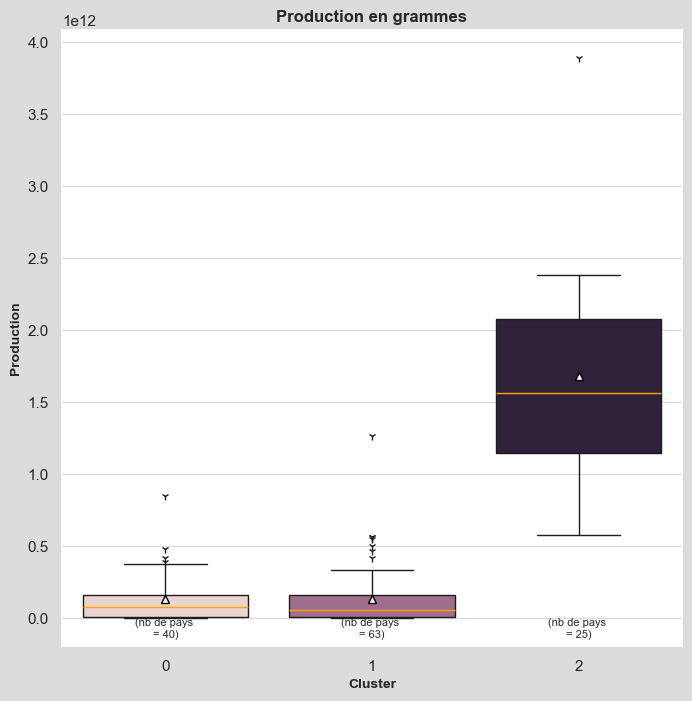

In [155]:
#Production
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters_3_var, x="cluster_kmeans", y="Production en grammes", hue="cluster_kmeans", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Production', fontweight='bold', fontsize=10)
plt.title('Production en grammes', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters_3_var.groupby('cluster_kmeans')['country'].count().reset_index()
plt.text(0, 0,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, 0,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, 0,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)

plt.savefig("kmeans_box_prod.png", bbox_inches='tight')
plt.show()

Le cluster 3 semble déjà être déjà gros producteur de poulet, nous l'éviterons pour nos recommandations, la concurrence y sera nécessairement trop élevées.

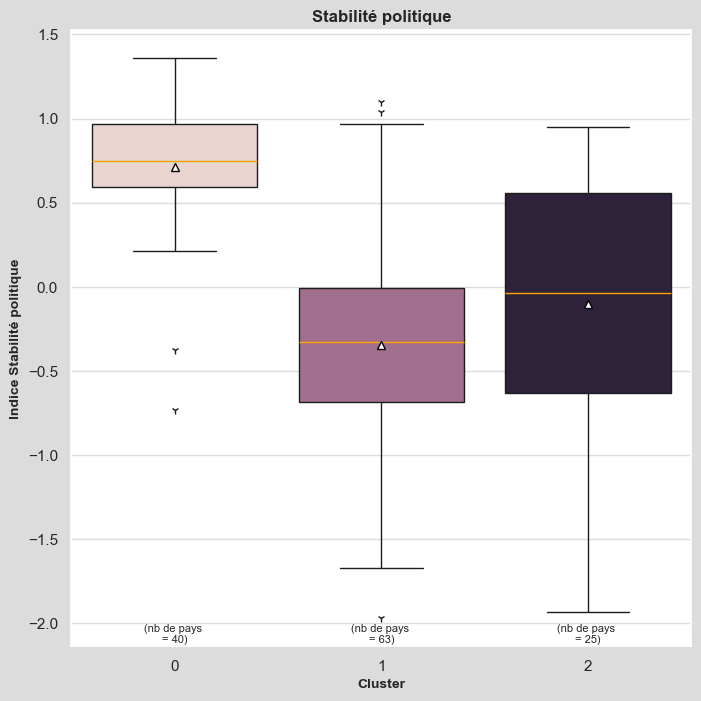

In [157]:
#Stabilité politique
sns.set(rc={'figure.figsize':(8,8), 'axes.facecolor':'white', 'figure.facecolor':'gainsboro'})
dendro_box_gdp = sns.boxplot(data=clusters_3_var, x="cluster_kmeans", y="Political Stability", hue="cluster_kmeans", flierprops={"marker": "1"},
            medianprops={"color" : "orange"}, meanprops={"markerfacecolor":"white", "markeredgecolor":"black"},
            orient="v", showmeans=True, dodge=False)
plt.xlabel('Cluster', fontweight='bold', fontsize=10)
plt.ylabel('Indice Stabilité politique', fontweight='bold', fontsize=10)
plt.title('Stabilité politique', fontweight='bold', fontsize=12)
plt.legend('', frameon=False)
plt.grid(axis='y', color='gainsboro')

nb_pays = clusters_3_var.groupby('cluster_kmeans')['country'].count().reset_index()
plt.text(0, -2,"(nb de pays \n= {})".format(nb_pays.iloc[0, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)  
plt.text(1, -2,"(nb de pays \n= {})".format(nb_pays.iloc[1, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.text(2, -2,"(nb de pays \n= {})".format(nb_pays.iloc[2, 1]), horizontalalignment='center',
         verticalalignment='top', fontsize=8)
plt.savefig("kmeans_box_politique.png", bbox_inches='tight')
plt.show()

Le cluster 1 occupe un très bon score de stabilité politique.

## Visualisation des composantes principales

PC1 + PC2 expliquent environ 55% de la variance totale.

Ces deux composantes résument plus de la moitié de l’information du dataset.
La 3eme composante permet d'arriver à 70% d'explication de la variance totale.
La 4eme composante permet d'atteindre près de 80% d'explication de la variance totale.

In [158]:
pca_components = pd.DataFrame(pca.components_, columns=data.columns, index=[f'PC{i+1}' for i in range(len(pca.components_))])


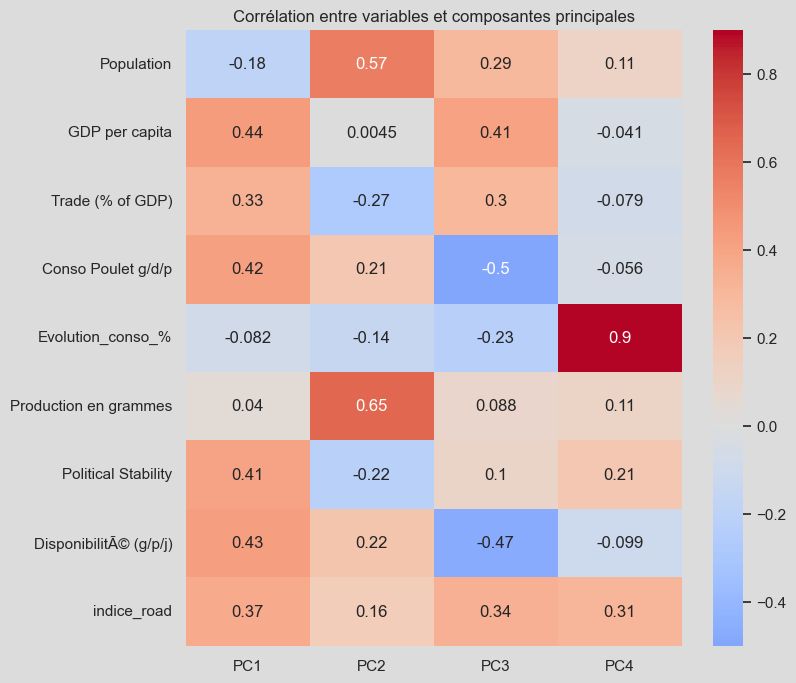

In [159]:
corr_matrix = pca_components.T
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Corrélation entre variables et composantes principales")
plt.savefig("heatmap_corr.png", bbox_inches='tight')
plt.show()


PC1 semble plutôt capturer un axe de développement économique et de consommation alimentaire (consommation et disponibilité pouulet)

Les pays avec un PIB élevé, une forte consommation de poulet, une meilleure infrastructure routière, et une stabilité politique obtiennent des valeurs élevées sur PC1.
Cela suggère que PC1 pourrait capturer une dimension de richesse et de consommation alimentaire.

Tandis que PC2 semble capturer un axe de production et de démographie. 
Les pays avec une grande production de poulet et une forte population ont des valeurs élevées sur PC2. À l'inverse, des pays avec un fort commerce international et une stabilité politique ont des valeurs plus basses.

Les pays avec un PIB élevé tendent à moins dépendre du commerce international dans ce contexte.

Le PC4 quant à lui capture principalement un potentiel d'évolution de consommation.

C:\Users\julie\AppData\Local\Temp\ipykernel_8068\1688535896.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(corr_matrix.index))


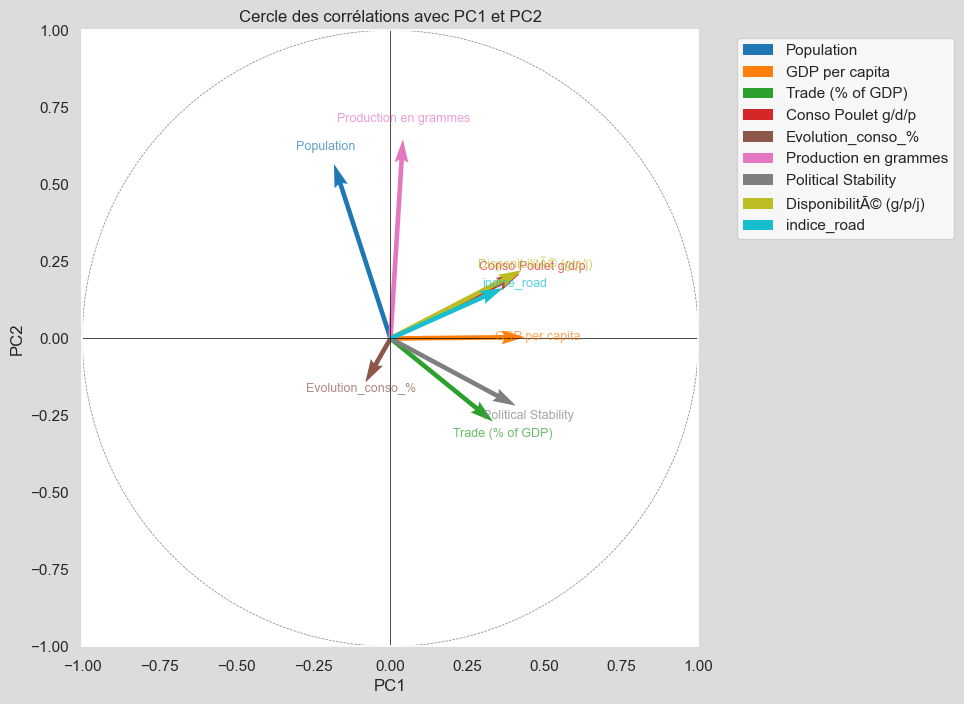

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Créer un graphique
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Tracer un cercle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=0.5)
ax.add_artist(circle)

# Créer une palette de couleurs (une couleur par vecteur)
colors = cm.get_cmap('tab10', len(corr_matrix.index))

# Tracer les vecteurs de corrélation pour chaque variable (PC1 et PC2)
for i, variable in enumerate(corr_matrix.index):
    # Les composantes principales (PC3 et PC4) sont les colonnes de corr_matrix
    x = corr_matrix.iloc[i, 0]
    y = corr_matrix.iloc[i, 1]
    
    # Assigner une couleur différente à chaque vecteur
    color = colors(i)

    # Tracer chaque vecteur avec sa couleur
    ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=color, label=variable)
    
    # Décalage automatique pour éviter les chevauchements
    offset_x = x * 1.1 if x >= 0 else x * 1.15
    offset_y = y * 1.1 if y >= 0 else y * 1.15

    # Ajouter le texte avec un léger décalage
    ax.text(offset_x, offset_y, variable, ha='center', va='center', fontsize=9, alpha=0.7, color=color)

# Définir les limites du graphique
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Titres et légende
ax.set_title('Cercle des corrélations avec PC1 et PC2')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Afficher la légende
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.grid(True)
plt.savefig("cercle_corr_1.png", bbox_inches='tight')
plt.show()


C:\Users\julie\AppData\Local\Temp\ipykernel_8068\1017045333.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(corr_matrix.index))


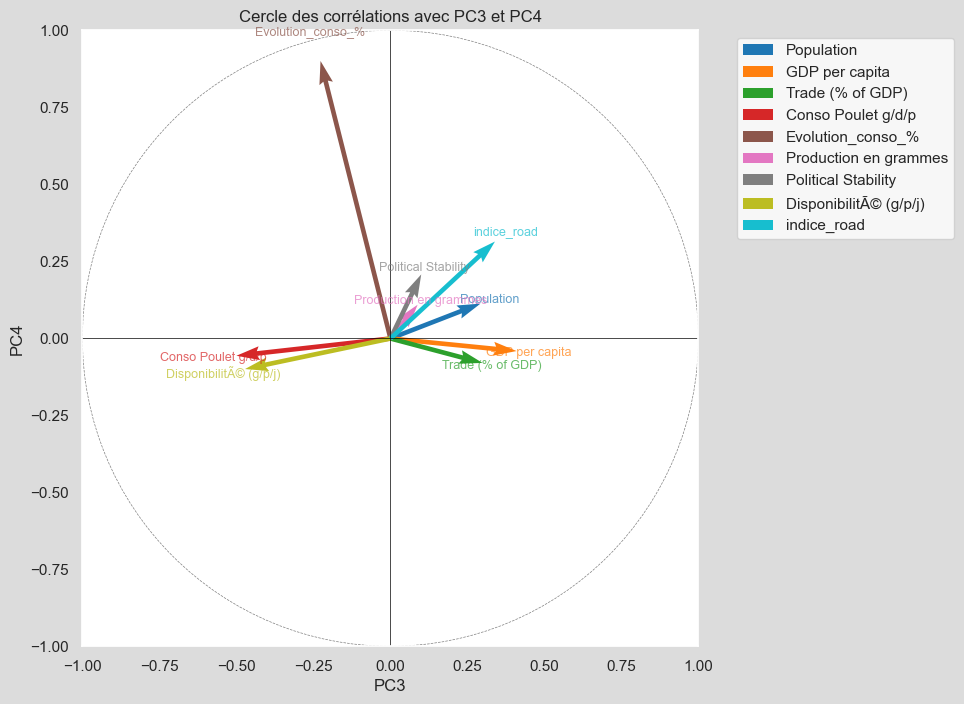

In [161]:
### import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Créer un graphique
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

# Tracer un cercle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', linewidth=0.5)
ax.add_artist(circle)

# Créer une palette de couleurs (une couleur par vecteur)
colors = cm.get_cmap('tab10', len(corr_matrix.index))

# Tracer les vecteurs de corrélation pour chaque variable (PC3 et PC4)
for i, variable in enumerate(corr_matrix.index):
    # Les composantes principales (PC3 et PC4) sont les colonnes de corr_matrix
    x = corr_matrix.iloc[i, 2]
    y = corr_matrix.iloc[i, 3]
    
    # Assigner une couleur différente à chaque vecteur
    color = colors(i)

    # Tracer chaque vecteur avec sa couleur
    ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color=color, label=variable)
    
    # Décalage automatique pour éviter les chevauchements
    offset_x = x * 1.1 if x >= 0 else x * 1.15
    offset_y = y * 1.1 if y >= 0 else y * 1.15

    # Ajouter le texte avec un léger décalage
    ax.text(offset_x, offset_y, variable, ha='center', va='center', fontsize=9, alpha=0.7, color=color)

# Définir les limites du graphique
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Ajouter des axes
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Titres et légende
ax.set_title('Cercle des corrélations avec PC3 et PC4')
ax.set_xlabel('PC3')
ax.set_ylabel('PC4')

# Afficher la légende
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.grid(True)
plt.savefig("cercle_corr_2.png", bbox_inches='tight')
plt.show()


### Projection des clusters

#### P1 & P2

In [162]:
# Réinitialisation de l'index
clusters_3 = clusters_3.reset_index()

In [163]:
centroids_df

,PC1,PC2,PC3,PC4,Cluster
0,1.804414,-0.620693,0.180551,-0.159990,0
1,-1.357872,-0.549688,-0.177751,0.014297,1
2,0.534774,2.378323,0.159050,0.219955,2


Clusters uniques dans clusters_3: [1 2 0]
Clusters uniques dans centroids_df: [0 1 2]


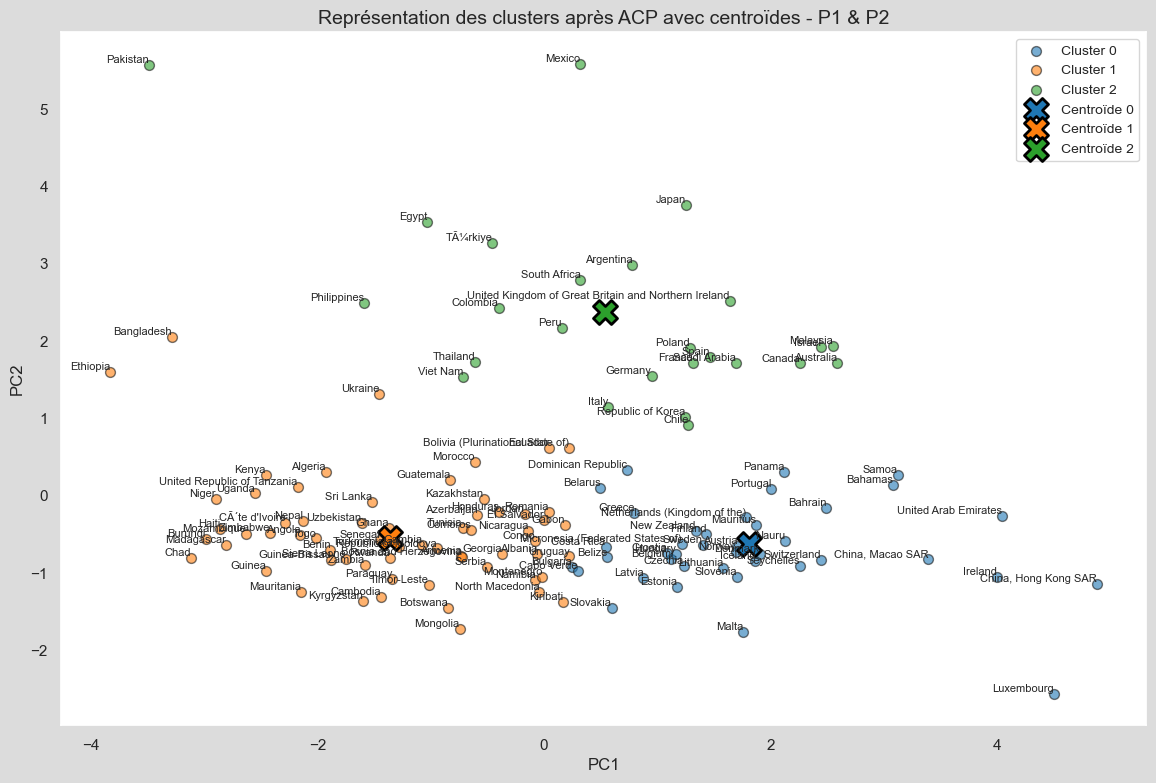

In [164]:
# Nouvelle palette de couleurs
palette = {
    0: "#1f77b4",  # Bleu
    1: "#ff7f0e",  # Orange
    2: "#2ca02c",  # Vert
    3: "#d62728",  # Rouge
    4: "#9467bd",  # Violet
    5: "#8c564b"   # Marron
}


# Création de la figure
plt.figure(figsize=(14, 9))
plt.title("Représentation des clusters après ACP avec centroïdes - P1 & P2", fontsize=14)

# Tracé des points pour chaque cluster
for cluster_id in range(3):  # Clusters de 0 à 5
    subset = clusters_3[clusters_3["Cluster"] == cluster_id]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {cluster_id}", 
                color=palette[cluster_id], alpha=0.6, edgecolors="k", s=50)
    
    # Ajout des noms des pays
    for i, row in subset.iterrows():
        plt.text(row["PC1"], row["PC2"], row["country"], fontsize=8, ha="right", va="bottom")

# Tracé des centroïdes avec la même couleur et une croix "X"
for cluster_id in range(3):
    centroid = centroids_df[centroids_df["Cluster"] == cluster_id]
    
    if centroid.empty:
        print(f"⚠ Attention : aucun centroïde trouvé pour Cluster {cluster_id}")
        continue
    
    plt.scatter(centroid["PC1"], centroid["PC2"], marker="X", s=300, 
                color=palette[cluster_id], edgecolors="black", linewidth=2, label=f"Centroïde {cluster_id}")

# Personnalisation des axes
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.legend(fontsize=10, loc="best")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("scatter_1.png", bbox_inches='tight')
plt.show()


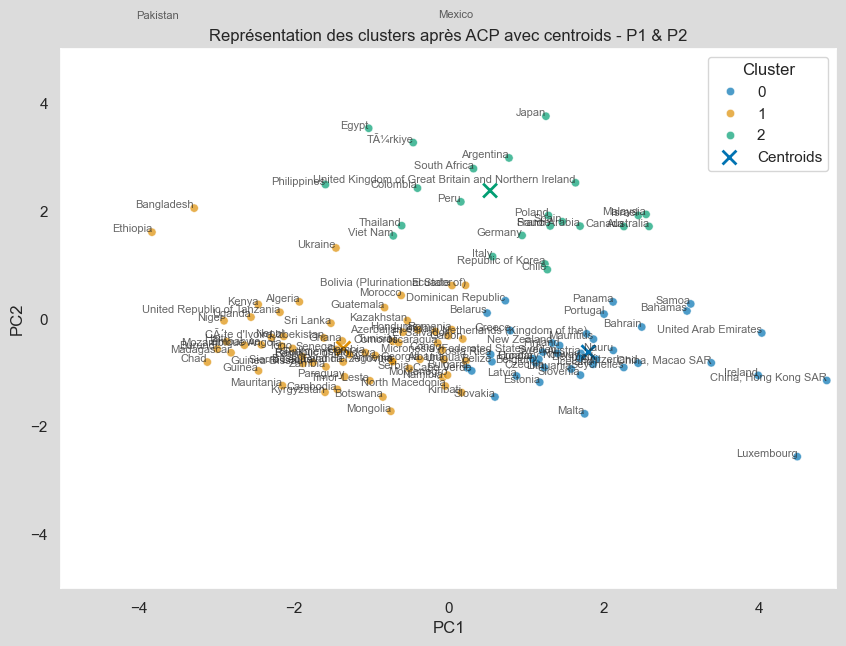

In [166]:
plt.figure(figsize=(10, 7))  # Taille ajustée pour plus de lisibilité

# Définir la palette des couleurs
palette = sns.color_palette("colorblind", len(clusters_3['Cluster'].unique()))

# Scatterplot des clusters avec la palette définie
sns.scatterplot(x=clusters_3['PC1'], y=clusters_3['PC2'], hue=clusters_3['Cluster'], palette=palette, alpha=0.7)

# Ajouter les centroïdes avec les mêmes couleurs que les clusters
plt.scatter(centroids_df.iloc[:, 0], centroids_df.iloc[:, 1], 
            marker="x", s=100, c=palette, label="Centroids", linewidths=2)

# Ajouter les noms des pays à chaque point
for i in range(len(clusters_3)):
    plt.text(clusters_3['PC1'].iloc[i], clusters_3['PC2'].iloc[i], clusters_3['country'].iloc[i], 
             fontsize=8, alpha=0.7, ha='right')

# Zoomer avec des limites manuelles forcées
plt.xlim(-5, 5)  # Ajuste ces valeurs pour le zoom désiré sur l'axe X
plt.ylim(-5, 5)

plt.title('Représentation des clusters après ACP avec centroids - P1 & P2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.savefig("scatter_2.png", bbox_inches='tight')
plt.show()


#### P3 & P4

Clusters uniques dans clusters_6: [1 2 0]
Clusters uniques dans centroids_df: [0 1 2]


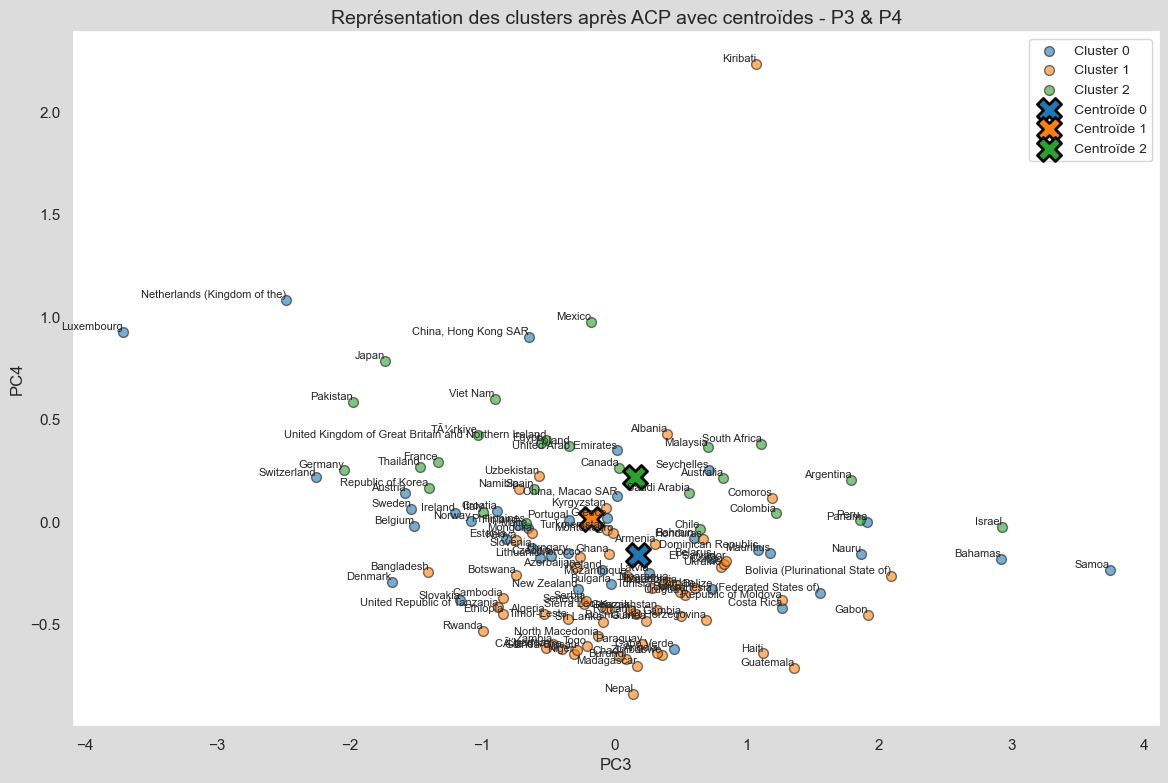

In [169]:
# Nouvelle palette de couleurs
palette = {
    0: "#1f77b4",  # Bleu
    1: "#ff7f0e",  # Orange
    2: "#2ca02c",  # Vert
    3: "#d62728",  # Rouge
    4: "#9467bd",  # Violet
    5: "#8c564b"   # Marron
}

# Vérification des clusters dans les deux DataFrames
print("Clusters uniques dans clusters_6:", clusters_3["Cluster"].unique())
print("Clusters uniques dans centroids_df:", centroids_df["Cluster"].unique())

# Création de la figure
plt.figure(figsize=(14, 9))
plt.title("Représentation des clusters après ACP avec centroïdes - P3 & P4", fontsize=14)

# Tracé des points pour chaque cluster
for cluster_id in range(3):  # Clusters de 0 à 2
    subset = clusters_3[clusters_3["Cluster"] == cluster_id]
    plt.scatter(subset["PC3"], subset["PC4"], label=f"Cluster {cluster_id}", 
                color=palette[cluster_id], alpha=0.6, edgecolors="k", s=50)
    
    # Ajout des noms des pays
    for i, row in subset.iterrows():
        plt.text(row["PC3"], row["PC4"], row["country"], fontsize=8, ha="right", va="bottom")

# Tracé des centroïdes avec la même couleur et une croix "X"
for cluster_id in range(3):
    centroid = centroids_df[centroids_df["Cluster"] == cluster_id]
    
    if centroid.empty:
        print(f"⚠ Attention : aucun centroïde trouvé pour Cluster {cluster_id}")
        continue
    
    plt.scatter(centroid["PC3"], centroid["PC4"], marker="X", s=300, 
                color=palette[cluster_id], edgecolors="black", linewidth=2, label=f"Centroïde {cluster_id}")

# Personnalisation des axes
plt.xlabel("PC3", fontsize=12)
plt.ylabel("PC4", fontsize=12)
plt.legend(fontsize=10, loc="best")
plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("scatter_3.png", bbox_inches='tight')
plt.show()


In [170]:
centroids_df

,PC1,PC2,PC3,PC4,Cluster
0,1.804414,-0.620693,0.180551,-0.159990,0
1,-1.357872,-0.549688,-0.177751,0.014297,1
2,0.534774,2.378323,0.159050,0.219955,2


### Inertie des pays

In [171]:
distances = pd.DataFrame(x_scaled, columns=data.columns)
distances['country'] = countries
distances_calc = pd.merge(clusters_3, distances, how='left', right_on='country',left_on='country')

In [172]:
features

Index(['Population', 'GDP per capita', 'Trade (% of GDP)',
       'Conso Poulet g/d/p', 'Evolution_conso_%', 'Production en grammes',
       'Political Stability', 'DisponibilitÃ© (g/p/j)', 'indice_road'],
      dtype='object')

In [173]:
distances_calc

,country,PC1,PC2,PC3,PC4,Cluster,Population,GDP per capita,Trade (% of GDP),Conso Poulet g/d/p,Evolution_conso_%,Production en grammes,Political Stability,DisponibilitÃ© (g/p/j),indice_road
0,Armenia,-0.729892,-0.776711,0.309807,-0.105405,1,-0.600741,-0.333744,0.456655,-0.219403,0.566975,-0.600918,-1.154943,-0.275853,-0.411250
1,Australia,2.585643,1.712866,0.818043,0.213310,2,0.028764,1.235927,-0.810981,1.695007,-0.208336,1.412282,1.190498,1.667836,0.739843
2,Ireland,3.994592,-1.050104,-1.206205,0.043327,0,-0.540402,3.391338,2.569720,0.709053,-1.632584,-0.409336,1.170157,1.378890,0.449567
3,Israel,2.448086,1.917302,2.925485,-0.022855,2,-0.431690,0.803021,-0.661664,3.037200,-0.487900,0.204810,-2.008555,3.133707,0.960052
4,Italy,0.567673,1.153773,-0.991073,0.049251,2,0.913753,0.992987,-0.504996,-0.097386,-0.385260,0.917340,0.742269,-0.137723,0.359482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,Honduras,-0.396708,-0.206588,0.665576,-0.083072,1,-0.394507,-0.830536,0.065317,0.070915,0.540677,-0.277794,-0.657927,0.199146,0.029168
124,"China, Hong Kong SAR",4.878910,-1.144790,-0.645607,0.902700,0,-0.480255,1.427245,4.648285,2.306497,0.073031,-0.586945,0.862795,1.456412,2.031068
125,Hungary,1.164321,-0.749964,-0.350825,-0.153276,0,-0.420171,0.495954,1.132497,0.202750,-0.673379,-0.082452,0.941809,0.068063,-0.140993
126,Croatia,1.085962,-0.742251,-0.885268,0.054727,0,-0.575231,0.518255,0.240608,-0.206780,0.366297,-0.535013,0.761597,-0.184236,1.460526


In [174]:
distances_calc.columns = distances_calc.columns.str.strip()  # Enlever les espaces
features_pca = ['PC1', 'PC2', 'PC3', 'PC4']  # Les features utilisées dans l'ACP

# Calcul de l'inertie sur les composantes principales
distances_calc['inertie'] = 0 
distances_calc['inertie'] = distances_calc['inertie'].astype(float) # Initialisation

for cluster_num in range(0, 3):  # Clusters 1 à 3
    cluster_data = distances_calc[distances_calc['Cluster'] == cluster_num]
    cluster_centroid = centroids_df.loc[centroids_df['Cluster'] == cluster_num, features_pca].squeeze()
    
    for feature in features_pca:
        distances_calc.loc[cluster_data.index, 'inertie'] += (cluster_data[feature] - cluster_centroid[feature]) ** 2




#### Inertie cluster 0

In [175]:
# Impression des inertie pour le cluster 0
clusters_dist_0 = distances_calc.loc[distances_calc['Cluster'] == 0].copy()
clusters_dist_0 = clusters_dist_0[['country', 'Cluster', 'inertie']]
clusters_dist_0.sort_values(by='inertie', ascending=False, inplace=True)
clusters_dist_0.to_csv('clusters_dist_0.csv', index=False, encoding='latin_1')
clusters_dist_0

,country,Cluster,inertie
83,Luxembourg,0,27.314106
80,Samoa,0,15.207270
124,"China, Hong Kong SAR",0,11.539054
15,Bahamas,0,9.695644
33,Netherlands (Kingdom of the),0,8.720194
2,Ireland,0,6.945706
64,Switzerland,0,6.502696
71,United Arab Emirates,0,5.414022
59,Slovakia,0,4.001103
41,Panama,0,3.980307


In [176]:
clusters_dist_0_merge = clusters_dist_0.merge(evolution_prod, how='left', left_on='country', right_on='country')
clusters_dist_0_merge = clusters_dist_0_merge.merge(obesite, how='left', left_on='country', right_on='country')
clusters_dist_0_merge

,country,Cluster,inertie,Evolution_prod,Obesity Rate %
0,Luxembourg,0,27.314106,0.000000,15.035378
1,Samoa,0,15.207270,-1.216835,46.154627
2,"China, Hong Kong SAR",0,11.539054,4.174218,29.999997
3,Bahamas,0,9.695644,-1.269351,25.035049
4,Netherlands (Kingdom of the),0,8.720194,-1.660937,11.607004
5,Ireland,0,6.945706,2.770676,21.167564
6,Switzerland,0,6.502696,-1.093914,10.145920
7,United Arab Emirates,0,5.414022,27.659574,23.491646
8,Slovakia,0,4.001103,1.592669,21.746793
9,Panama,0,3.980307,7.518788,24.670542


#### Inertie cluster 1

In [177]:
# Impression des inertie pour le cluster 1
clusters_dist_1 = distances_calc.loc[distances_calc['Cluster'] == 1].copy()
clusters_dist_1 = clusters_dist_1[['country', 'Cluster', 'inertie']]
clusters_dist_1.sort_values(by='inertie', ascending=False, inplace=True)
clusters_dist_1.to_csv('clusters_dist_1.csv', index=False, encoding='latin_1')
clusters_dist_1

,country,Cluster,inertie
38,Bangladesh,1,12.049383
79,Ethiopia,1,11.406392
117,Kiribati,1,9.494765
53,Bolivia (Plurinational State of),1,9.076194
112,Gabon,1,6.986366
...,...,...,...
57,Sierra Leone,1,0.434018
77,Uzbekistan,1,0.301028
55,Senegal,1,0.184520
116,Ghana,1,0.066025


In [179]:
clusters_dist_1_merge = clusters_dist_1.merge(evolution_prod, how='left', left_on='country', right_on='country')
clusters_dist_1_merge = clusters_dist_1_merge.merge(obesite, how='left', left_on='country', right_on='country')
clusters_dist_1_merge

,country,Cluster,inertie,Evolution_prod,Obesity Rate %
0,Bangladesh,1,12.049383,2.539979,3.615856
1,Ethiopia,1,11.406392,15.716936,1.476397
2,Kiribati,1,9.494765,2.185680,1056.364597
3,Bolivia (Plurinational State of),1,9.076194,2.336542,17.967751
4,Gabon,1,6.986366,0.802760,12.073460
...,...,...,...,...,...
58,Sierra Leone,1,0.434018,1.097378,3.545885
59,Uzbekistan,1,0.301028,14.370968,19.073100
60,Senegal,1,0.184520,4.436064,4.978544
61,Ghana,1,0.066025,14.734344,7.399095


#### Inertie cluster 2

In [180]:
# Impression des inertie pour le cluster 2
clusters_dist_2 = distances_calc.loc[distances_calc['Cluster'] == 2].copy()
clusters_dist_2 = clusters_dist_2[['country', 'Cluster', 'inertie']]
clusters_dist_2.sort_values(by='inertie', ascending=False, inplace=True)
clusters_dist_2.to_csv('clusters_dist_2.csv', index=False, encoding='latin_1')
clusters_dist_2

,country,Cluster,inertie
40,Pakistan,2,31.018903
3,Israel,2,11.585421
24,Mexico,2,11.014743
8,Japan,2,6.307921
114,Germany,2,5.711636
45,Philippines,2,5.264270
1,Australia,2,5.083212
13,Republic of Korea,2,4.796028
20,Malaysia,2,4.569468
67,Thailand,2,4.364437


In [181]:
clusters_dist_2_merge = clusters_dist_2.merge(evolution_prod, how='left', left_on='country', right_on='country')
clusters_dist_2_merge = clusters_dist_2_merge.merge(obesite, how='left', left_on='country', right_on='country')
clusters_dist_2_merge

,country,Cluster,inertie,Evolution_prod,Obesity Rate %
0,Pakistan,2,31.018903,9.256449,12.525025
1,Israel,2,11.585421,5.106786,15.124811
2,Mexico,2,11.014743,2.815442,24.895992
3,Japan,2,6.307921,0.531783,4.743873
4,Germany,2,5.711636,0.929368,16.795147
5,Philippines,2,5.264270,5.188369,5.657526
6,Australia,2,5.083212,4.956857,23.439458
7,Republic of Korea,2,4.796028,-0.216216,6.376967
8,Malaysia,2,4.569468,1.372328,15.373097
9,Thailand,2,4.364437,2.061416,12.412410


Les paragons sont la Pologne pour le cluster 2, le Turkmenistan pour le cluster 1, et l'Islande pour le cluster 0

Inertie faible (proche du centroïde) → Le pays est bien représentatif du cluster. Il partage des caractéristiques communes avec d’autres pays du même groupe.
Inertie élevée (éloigné du centroïde) → Le pays est plus atypique par rapport aux autres pays du cluster. Il pourrait être mal classé ou être un cas limite entre plusieurs clusters.
L’inertie aide à identifier les pays les plus "représentatifs" d’un cluster et ceux qui pourraient être des opportunités atypiques. 

## Recommandations

Nos marchés cibles seront donc :

 Les pays du cluster 0, qui ont à la fois la plus forte demande intérieure en poulet
et avec lesquels les échanges seront le plus facilités ;

 Ainsi que dans un second temps les pays du cluster 2 dont les caractéristiques
sont proches du cluster 0.
Pour ça, on peut s'aider du nuage de point pour identifier des pays avec un haut potentiel dans le cluster 2

Cluster 0 :
Pays d'europe consommateurs de poulet : Luxembourg, Suisse, Irlande, Islande, Allemagne, Autriche. (Il y a un marché, réglementé par les mêmes normes UE, introduction facilitée).
On peut dores et déjà établir une priorité sur le Luxembourg, l'Irlande, et Malte, qui gardent tous une certaine ouverture aux échanges, et possédant des infrastructures de transport de qualité (routes), permettant un acheminement à moindres coûts et en sécurité.
La Belgique et la Suisse sont également des pays prometteurs puisqu'ils tendent à baisser leur production locale malgré une consommation élevé en poulet.

Pour pouvoir élargir la liste de nos pays cibles, on pourrait procéder à une étude de compétitivité prix. La concurrence est très forte avec les grands pays exportateurs tels que le Brésil, les Etats Unis ou encore l'Inde. De plus, un grand pays producteur de poulet est actuellement en stand by : l'Ukraine, dû à la situation actuelle géopolitique. Lorsque les exports ukrainien reprendront, cela pourra impacter fortement notre implantation sur certains marchés.

Hors Europe, quelques pays se démarquent par leurs habitudes de consommation ainsi que leur situation économique, permettant une éventuelle implantation hors Europe. Parmi eux, on peut citer le Costa Rica, l'Uruguay ou le Panama. Ces pays sont également identifiables à haut potentiel de consommation notamment sur la projection sur la 3eme composante. Cependant, cette implantation doit s'envisager après une ouverture progressive à des marchés plus accessibles et lorsque l'entreprise pourra proposer des prix compétitifs avec les poids lourds du marché tels que le Brésil ou les USA.!

La France n'est plus autosuffisante en poulet, il y a également des opportunités à creuser sur ce secteur là, notamment sur les découpes de qualité supérieur.